https://www.kaggle.com/code/waltermaffy/fruit-classification-pca-svm-knn-decision-tree

In this work the Fruits360 dataset contains 131 class of different fruits and 90380 total images. The goal of this implementation is to perform different classification algorithms, in particular SVM, K-NN, Decision Tree, firstly for a binary classification task, then for a multi-class one. I'll also apply Principal Component Analysis in order to reduce the dimensionality of the dataset, see the variance of each class and then I'll try to apply classification algorithm having only two dimension. At the end I'll make a comparison between all methods in order to find which of them perform better on this dataset.

In [2]:
# ALL LIBRERS :
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

#print(os.listdir("../"))
dim = 100

In [3]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            p = path + f
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

I've implemented two function in order to choose the fruit you want, for binary classification I've decided to take Cocos and Pineapple cause they look similar and so the classification task will be not too easy.

In [4]:
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos'] #Binary classification

#Get Images and Labels
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

#Get data for k-fold
X,y = getYourFruits(fruits, '', print_n=True, k_fold=True)
print(X_test.shape)
#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

There are  490   TRAINING  images of  PINEAPPLE
There are  490   TRAINING  images of  COCOS
There are  166   TEST  images of  PINEAPPLE
There are  166   TEST  images of  COCOS
(332, 100, 100, 3)


Each image is converted in a 100x100 numpy array for each RGB dimension (x3). Then has been flatted in one single vector (Image Features Vector) and then scaled subtracting the mean of the dataset in order to perform classification algorithms.

VISUALIZATION OF DATA
Let's see now how one of our samples appears

In [5]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

Pineapple


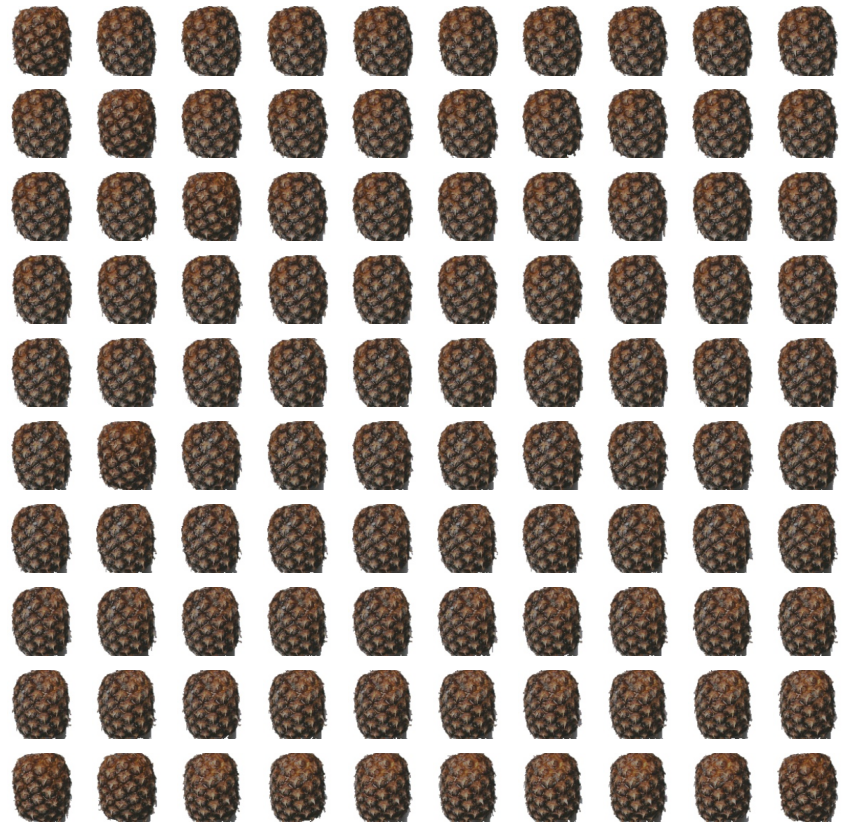

In [17]:
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

Cocos


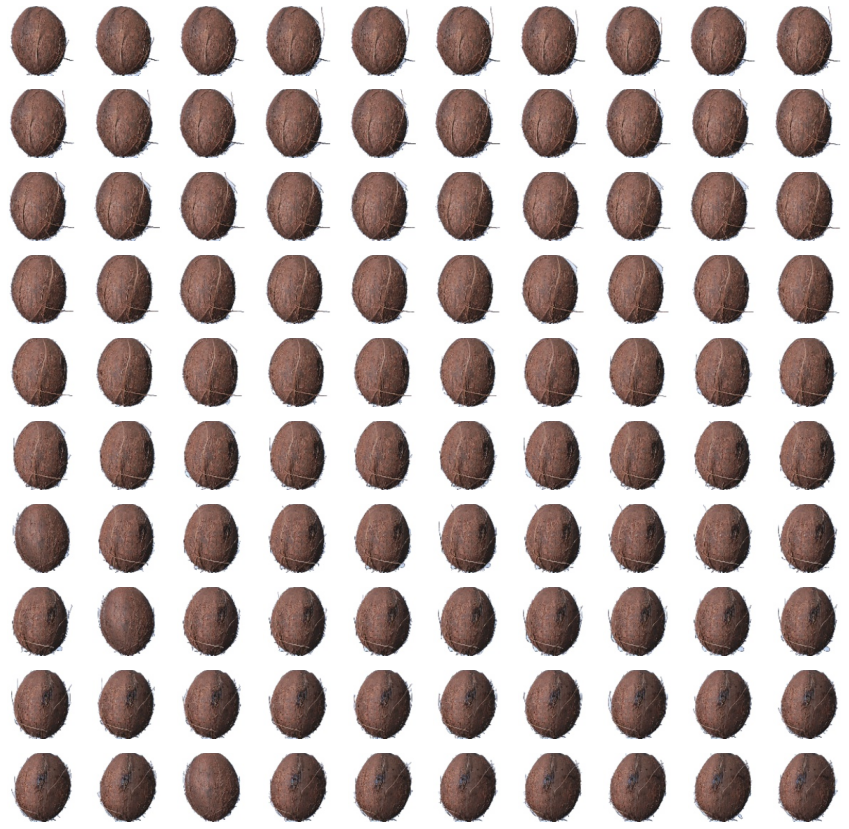

In [15]:
print(fruits[y_train[490]])
plot_image_grid(X_t[490:590], 10, 10)

In [8]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')

    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=fruits, yticklabels=fruits,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

DATA IN LOWER DIMENSIONS

In order to discover how our data appears in lower dimension we need to reduce dimensionality of the dataset in 2 or 3 dimension so that we can plot and visualize them. To do this I've decided to use Principal Component Analysis, explained in the next chapter, but a better solution could be use t-SNE (T-distributed Stochastic Neighbor Embedding) or MDS (Multi Dimensional Scaling), nonlinear dimensionality reduction techniques well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.
No assumption about linearity of the dataset could be make considering those graphs.

PRINCIPAL COMPONENT ANALYSIS

Principal Component Analysis is a technique used in order to reduce the dimensionality of a dataset while preserving as mush information as possible. Data is reprojected in a lower dimensional space, in particular we need to find a projection that minimizes the squared error in reconstructing the original data.

DATA IN 2D

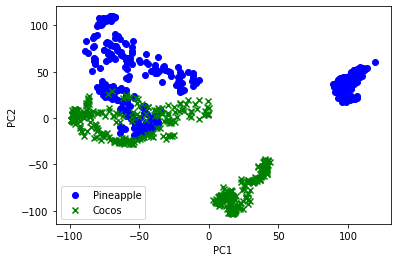

In [9]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

DATA IN 3D

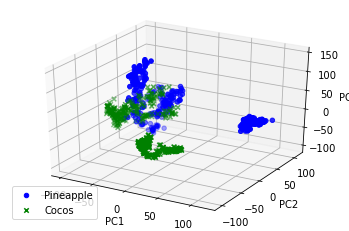

In [10]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

BINARY CLASSIFICATION

Let's start now to classify our dataset, firstly we take only two class in order to perform a classic binary classification, at the end the entire dataset (or a sub-part of it) will be classified. I'll use 3 different technique: SVM, K-NN, Decision Tree.
At the end of the Binary Classification there will be a comparison between all the methods.

K-FOLD CROSS VALIDATION

Dataset is divided yet in Training and Test set by the authors of the dataset it self.
In proportion approximately 75% Training images, 25% Test images.
Models will be trained considering only Training set and then Test set will be used in order to evaluate their performance in terms of accuracy.
This approach not always the best choice, because due to sample variability between training and test set, our model could gives a better prediction on training data but fail to generalize on test data; and the subset choosen could have bias and not be representative of the entire dataset.

From this problem comes the technique of Cross-validation.
Cross-validation is a statistical technique which involves partitioning the data into subsets, training the data on a subset and use the other subset to evaluate the model’s performance. To reduce variability we perform multiple rounds of cross-validation with different subsets from the same data. We combine the results from these multiple rounds to come up with an estimate of the model’s predictive performance.
Cross-validation will give us a more accurate estimate of a model’s performance.

K-FOLD Cross Validation in particular involves randomly dividing the dataset into k groups or folds of approximately equal size.
The first fold is kept for testing and the model is trained on k-1 folds.
The process is repeated K times and each time different fold or a different group of data points are used for validation.

SUPPORT VECTOR MACHINES 

A Support Vector Machine (SVM)
is a supervised classification method, that after a training phase can identify if a new point belongs to a class or another with the highest mathematically accuracy. It's a binary classification method, but using an approach called One vs All is possible to use SVM for multi-class classification.
If a dataset is linearly separable it means that we could use a Hard margin approach, or rather find the two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible and so we are being able to identify to which class belongs each point of the dataset. But mostly of the time datasets are not linearly separable and so we can take two ways, one is to continue using a Linear approach using Soft Margin, or simplifying, admitting some misclassification. While the second way is to use a Non-Linear Kernel (that must satisfy Mercer Condition) or rather a mapping of the data on a higher dimensional space, where the data is linearly separable and the classification task can be solved easly,without even need to calculate the points projections.

LINEAR SVM

Accuracy with SVM: 97.59%


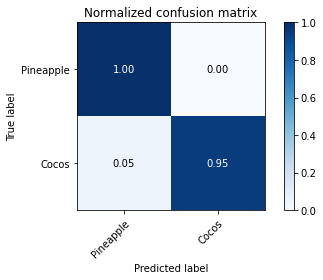

In [14]:
svm = SVC(gamma='auto', kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred,classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

SVM + K-FOLD

In [15]:
pred_kfold = cross_val_score(svm, X, y, cv=5)
print("Accuracy with SVM and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(),pred_kfold.std() * 2))

Accuracy with SVM and K-FOLD CROSS VALIDATION: 0.97 (+/- 0.07)


K-NEAREST NEIGHBOR

K-NN is a supervised learning method that considers the K closest training examples to the point of interest for predicting its class. The point is assigned to the class that is closest.
Could be applied different distance metrics such as: Euclidian, Weighted, Gaussian, etc. Steps are pretty easy:

 Receive an unclassified data

Measure the distance with choosen metrics from the new data to all others data that are already classified.

 Gets the K smaller distances

 Check the list of classes that had the shortest distance and count the amount of each class that appears

Takes as correct class the class that appeared the most times

Classifies the new data with the class that you took in previous step

Accuracy with K-NN: 98.80%


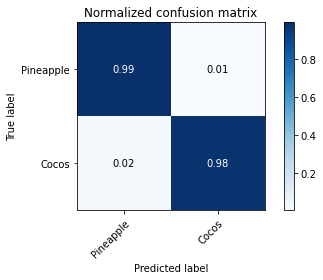

In [34]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)

In [35]:
#KNN + K-FOLD
pred_kfold = cross_val_score(knn, X, y, cv=5)
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 0.96 (+/- 0.07)


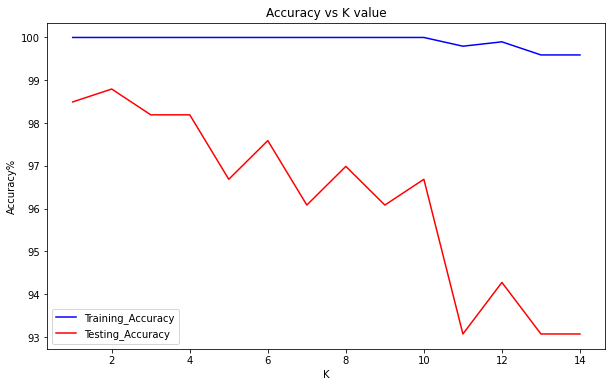

In [36]:
#CHANGING VALUES OF N
accuracy_train = []
accuracy_test = []

for i in range(1,15):   #check all possible values for 1 to 15
    k_nn = KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(X_train,y_train)
    pred_i = k_nn.predict(X_test)
    accuracy_train.append(k_nn.score(X_train,y_train)*100)
    accuracy_test.append(k_nn.score(X_test,y_test)*100)

accuracy_train_array=np.asarray(accuracy_train)
accuracy_test_array=np.asarray(accuracy_test)

plt.figure(figsize=(10,6))
plt.plot(range(1,15),accuracy_train_array, label='Training_Accuracy', color='blue')
plt.plot(range(1,15),accuracy_test_array, label='Testing_Accuracy', color='red')
plt.legend()
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy%')

plt.show()

COMMENT
From this graph is possible to understand how the best value of K is equal to 2, because the Test Accuracy reaches the best accuracy score and then start decreasing.

Training accuracy still maintain 100% accuracy starting decreasing for last numbers of K

DECISION TREE
In a decision tree each intermediate node of the tree contains splitting attributes used to build different paths, while leaves contains class labels.

There are differt algorithms to build a decision tree, all are made with a greedy approach, optimal locally.
The most famous is Hunt's algoritm.
Strarting from an empty tree, we need to find iteratively best attribute on which split the data locally at each step. If a subset contains records that belongs to the same class then the leaf containing such class label is created, otherwise if a subset is empty is assigned to default to mayor class.

Critical points of decision trees are test condition, the selection of the best attribute and the splitting condition. For the selection of the best attribute is generally choosen the attribute that generate homogeneus nodes. There are different metrics in order to find the best splitting homogenity, the most common are:

GINI IMPURITY INDEX: Given  𝑛  classes and  𝑝𝑖  the fraction of items of class  𝑖  in a subset p, for  𝑖 ∈{1,2,...,n}. Then the GINI index is defined as:
𝐺𝐼𝑁𝐼=1−∑𝑖=1𝑛𝑝2𝑖

INFORMATION GAIN RATIO: The information gain is based on the decrease of entropy after a data-set is split on an attribute. Constructing a decision tree is all about finding attribute that returns the highest information gain (i.e., the most homogeneous branches).
Entropy is defined as  𝐻(𝑖)=−∑𝑛𝑖=1𝑝𝑖log2𝑝𝑖 .
So then Information gain is defined as:

𝐼𝐺=𝐻(𝑝)−𝐻(𝑝,𝑖)=𝐻(𝑝)−∑𝑖=1𝑛𝑛𝑖𝑛𝐻(𝑖)

where p is the parent node. Advantages of Decision Trees are velocity, easy to interpretate and good accuracy, but they could be affected by missing values.

Accuracy with Decision Tree: 65.36%


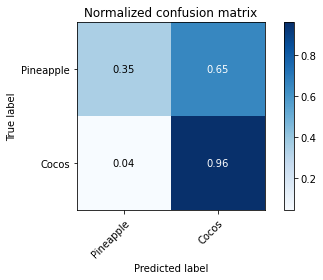

In [24]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = tree.predict_proba(X_test)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, probs)
tree_auc = metrics.roc_auc_score(y_test, probs)

In [28]:
#DECISION TREE + K-FOLD
pred_kfold = cross_val_score(tree, X, y, cv=5)
print("Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with DECISION TREE and K-FOLD CROSS VALIDATION: 0.92 (+/- 0.17)


MODEL EVALUATION

In order to find the most suitable algorithm to this dataset, different evaluation methods will be presented: Accuracy, Confusion Matrix, ROC Curve.
Given:

TP = #samples for which the prediction is Fruit1 and the true label is Fruit1
FP = #samples for which the prediction is Fruit2 but the true label is Fruit1
TN = #samples for which the prediction is Fruit2 and the true label is Fruit2
FN = #samples for which the prediction is Fruit1 but the true label is Fruit2
We can define:

*ACCURACY:  𝑇𝑃+𝑇𝑁𝑇𝑃+𝐹𝑃+𝑇𝑁+𝐹𝑁  that is the percentage of samples classified correctly. *

CONFUSION MATRIX: A simple table with previous values used to show performance of a classifier

ROC CURVE: Area Under the Receiver Operating Characteristic curve (AUC)

To introduce this concept, we define the following two metrics:

True positive rate (TPR): TPR = recall =  𝑇𝑃𝐹𝑁+𝑇𝑃


False positive rate (FPR): FPR =  𝐹𝑃𝑇𝑁+𝐹𝑃

In order to plot the Receiver Operating Characteristic (ROC) curve we need to compute TPR and FPR and choose a number of thresholds for the classification (AUG). Area under the ROC curve, performed plotting TPR and FPR is used as evaluation matrics for the different classifiers.

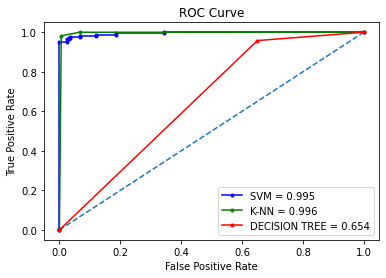

In [33]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(tree_fpr, tree_tpr, 'r', marker='.',label = 'DECISION TREE = %.3f' % tree_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

COMMENT:
SVM and K-NN performs better with this classification with an AUC = 0.99x, instead Decision Tree is worst with an AUC of 0.65

MULTI-CLASS CLASSIFICATION

In [34]:
fruits = ['Orange', 'Banana' , 'Strawberry', 'Apple Golden 1', 'Kiwi' , 'Lemon', 'Cocos' , 'Pineapple' , 'Peach', 'Cherry 1', 'Cherry 2', 'Mandarine']
#fruits = getAllFruits() #Be sure to have enough free memory

#Get Images and Labels
X, y =  getYourFruits(fruits, 'Training')
X_test, y_test = getYourFruits(fruits, 'Test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

In [36]:
#SVM
model = SVC(gamma='auto', kernel='linear')
model.fit(X_train, y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

#K-NN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))

#DECISION TREE
model = DecisionTreeClassifier()
model.fit(X_train,y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))

Accuracy with SVM: 98.04%
Accuracy with K-NN: 91.74%
Accuracy with Decision Tree: 76.39%


COMMENT
SVM is the classification algorithm that performs better in the multi-class classification task.